In [9]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv("data/XAUUSD_1H_BID_20241001-20241014.csv")
prices = df['Close'].values
prices

array([2636.255, 2639.675, 2636.318, 2637.845, 2639.464, 2642.955,
       2645.165, 2645.485, 2646.425, 2648.565, 2650.225, 2650.178,
       2651.435, 2667.528, 2658.895, 2663.315, 2666.315, 2662.298,
       2660.945, 2658.588, 2663.005, 2663.005, 2661.895, 2660.218,
       2657.325, 2660.495, 2659.998, 2655.238, 2653.958, 2647.875,
       2649.615, 2655.315, 2652.335, 2652.815, 2649.015, 2649.448,
       2649.488, 2659.344, 2647.945, 2649.835, 2649.638, 2652.025,
       2653.998, 2658.498, 2658.345, 2658.345, 2659.334, 2660.135,
       2657.675, 2658.105, 2655.665, 2655.878, 2654.845, 2653.198,
       2655.714, 2645.145, 2644.985, 2644.685, 2646.675, 2647.935,
       2642.235, 2646.925, 2650.068, 2648.735, 2659.925, 2656.595,
       2657.398, 2657.815, 2655.715, 2655.715, 2655.844, 2655.615,
       2657.098, 2658.115, 2661.908, 2660.985, 2663.915, 2667.278,
       2660.148, 2660.888, 2658.894, 2657.365, 2658.145, 2661.205,
       2638.695, 2651.778, 2658.255, 2653.045, 2645.168, 2649.

### FFT for the whole data length

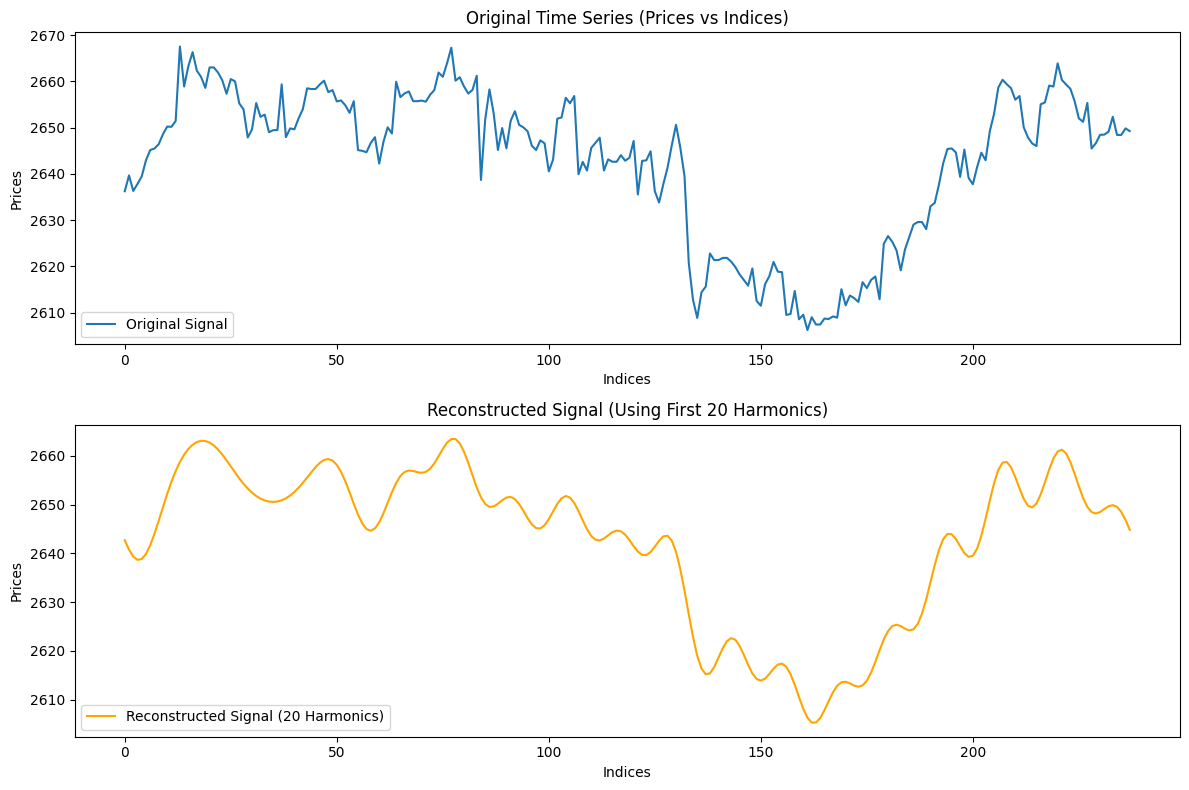

In [2]:
# Create time indices based on the length of prices (0 to len(prices) - 1)
time_indices = np.arange(len(prices))

# Perform FFT
N = len(prices)
fft_result = np.fft.fft(prices)
fft_freq = np.fft.fftfreq(N)  # Compute frequency bins

# Only need positive frequencies for real signals
positive_freq_indices = fft_freq >= 0
fft_freq_positive = fft_freq[positive_freq_indices]
fft_result_positive = fft_result[positive_freq_indices]

# Retain only the first few harmonics, including the DC component
num_harmonics = 20  # Adjust this number as needed
frequencies = fft_freq_positive[:num_harmonics]
amplitudes = fft_result_positive[:num_harmonics]

# Reconstruct the signal using the selected harmonics
reconstructed_signal = np.zeros(N)

for i in range(num_harmonics):
    frequency = frequencies[i]
    amplitude = np.abs(amplitudes[i])
    phase = np.angle(amplitudes[i])
    if frequency == 0:
        # DC component (mean value)
        reconstructed_signal += (amplitude / N) * np.ones(N)
    else:
        # Harmonic components
        omega = 2 * np.pi * frequency
        reconstructed_signal += (2 * amplitude / N) * np.cos(omega * time_indices + phase)

# Plot original time series data
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time_indices, prices, label="Original Signal")
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot the reconstructed signal using only a few harmonics
plt.subplot(2, 1, 2)
plt.plot(time_indices, reconstructed_signal, label=f"Reconstructed Signal ({num_harmonics} Harmonics)", color='orange')
plt.title(f"Reconstructed Signal (Using First {num_harmonics} Harmonics)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()


### Forecasting, excluding last N data

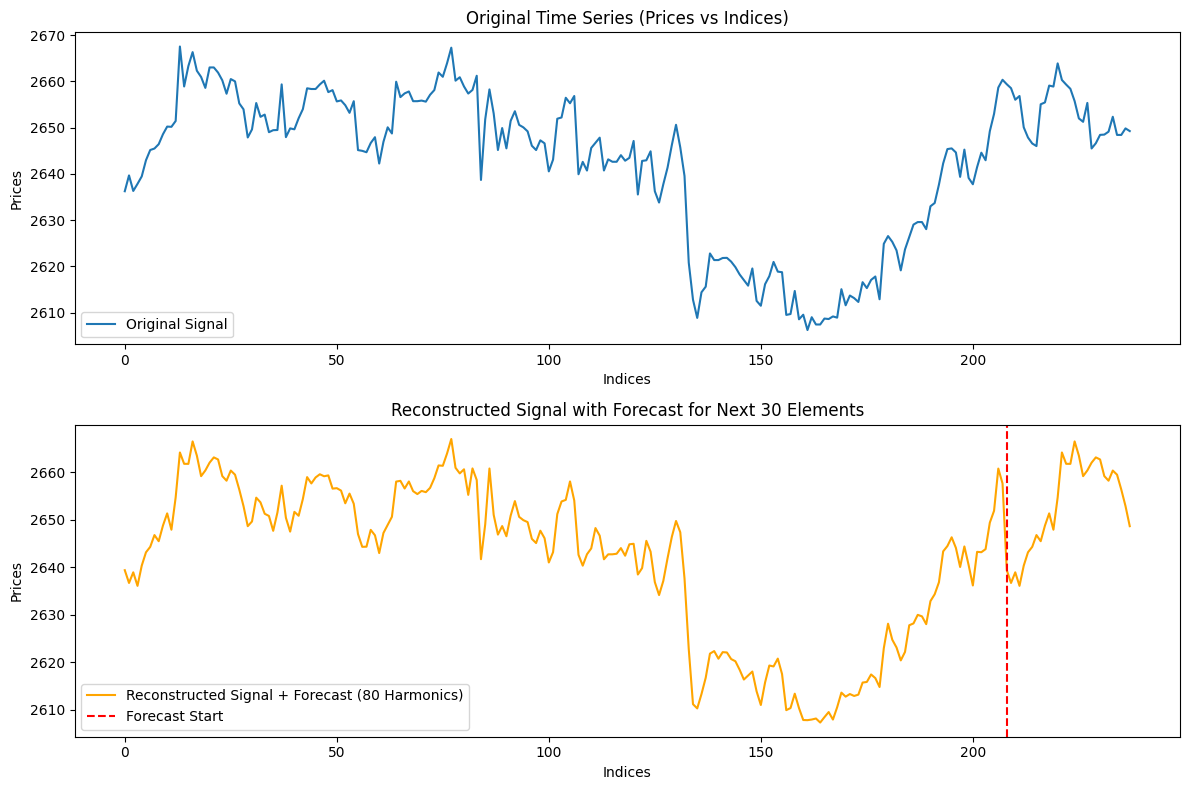

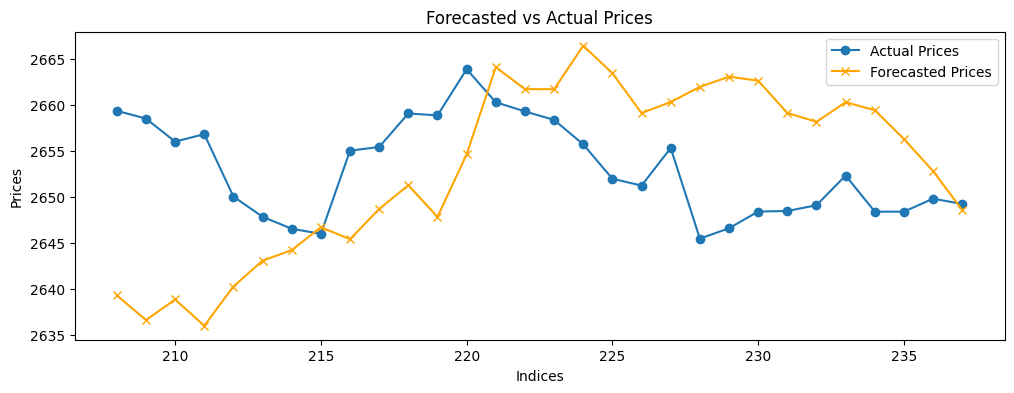

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define how many elements to exclude (e.g. last 48)
exclude_elements = 24
prices_for_fft = prices[:-exclude_elements]  # Remove the last 48 elements for FFT

# Perform FFT on the data excluding the last 48 elements
N = len(prices_for_fft)
fft_result = np.fft.fft(prices_for_fft)
fft_freq = np.fft.fftfreq(N)  # Compute frequency bins

# Only need positive frequencies for real signals
positive_freq_indices = fft_freq >= 0
fft_freq_positive = fft_freq[positive_freq_indices]
fft_result_positive = fft_result[positive_freq_indices]

# Retain the first few harmonics, including the DC component
num_harmonics = 80
frequencies = fft_freq_positive[:num_harmonics]
amplitudes = fft_result_positive[:num_harmonics]

# Create extended indices including future points
total_length = len(prices)
extended_indices = np.arange(total_length)

# Reconstruct the signal using the selected harmonics
reconstructed_signal = np.zeros(total_length)

for i in range(num_harmonics):
    frequency = frequencies[i]
    amplitude = np.abs(amplitudes[i])
    phase = np.angle(amplitudes[i])
    if frequency == 0:  # DC component
        # DC component (mean value)
        reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
    else:
        # Other harmonics
        omega = 2 * np.pi * frequency
        reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)

# Get actual hidden prices (the last 48 points)
prices_test = prices[-exclude_elements:]

# Plot original time series data and the forecast
plt.figure(figsize=(12, 8))

# Plot original signal
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(prices)), prices, label="Original Signal")
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot the reconstructed signal with forecast
plt.subplot(2, 1, 2)
plt.plot(extended_indices, reconstructed_signal, label=f"Reconstructed Signal + Forecast ({num_harmonics} Harmonics)", color='orange')
plt.axvline(x=len(prices) - exclude_elements, color='red', linestyle='--', label="Forecast Start")
plt.title(f"Reconstructed Signal with Forecast for Next {exclude_elements} Elements")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()

# Compare the forecasted values with the actual hidden values
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(prices) - exclude_elements, len(prices)), prices_test, label='Actual Prices', marker='o')
plt.plot(np.arange(len(prices) - exclude_elements, len(prices)), reconstructed_signal[-exclude_elements:], label='Forecasted Prices', marker='x', color='orange')
plt.title('Forecasted vs Actual Prices')
plt.xlabel('Indices')
plt.ylabel('Prices')
plt.legend()
plt.show()


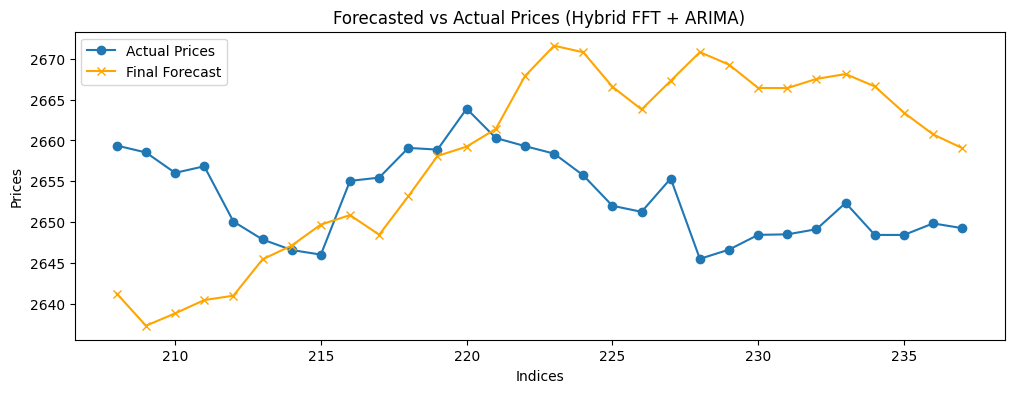

In [14]:
# Forecast the long-term trend with FFT
reconstructed_signal = np.zeros(total_length)
for i in range(num_harmonics):
    frequency = frequencies[i]
    amplitude = np.abs(amplitudes[i])
    phase = np.angle(amplitudes[i])
    if frequency == 0:  # DC component
        reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
    else:
        omega = 2 * np.pi * frequency
        reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)

# Now forecast the residuals or short-term dynamics using ARIMA
residuals = prices_for_fft - reconstructed_signal[:len(prices_for_fft)]
model = ARIMA(residuals, order=(6,2,0))  # Adjust ARIMA parameters as needed
model_fit = model.fit()
forecast_residuals = model_fit.forecast(steps=exclude_elements)

# Combine FFT forecast with ARIMA forecast for the residuals
final_forecast = reconstructed_signal[-exclude_elements:] + forecast_residuals

# Plot final forecast
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(prices) - exclude_elements, len(prices)), prices_test, label='Actual Prices', marker='o')
plt.plot(np.arange(len(prices) - exclude_elements, len(prices)), final_forecast, label='Final Forecast', marker='x', color='orange')
plt.title('Forecasted vs Actual Prices (Hybrid FFT + ARIMA)')
plt.xlabel('Indices')
plt.ylabel('Prices')
plt.legend()
plt.show()
